Importação e preparação dos dados:

 Aqui, juntamos os dados coletados em um único objeto 'dados'.
 Em seguida, removemos colunas que não serão usadas nesta etapa da análise.

In [12]:
csv_grupo <- read.csv('/content/csv_grupo.csv', sep = ";", header = TRUE)
dados <- rbind(csv_grupo)
dados <- dados[, -c(1,2,7)]

# Entendendo as amostas:

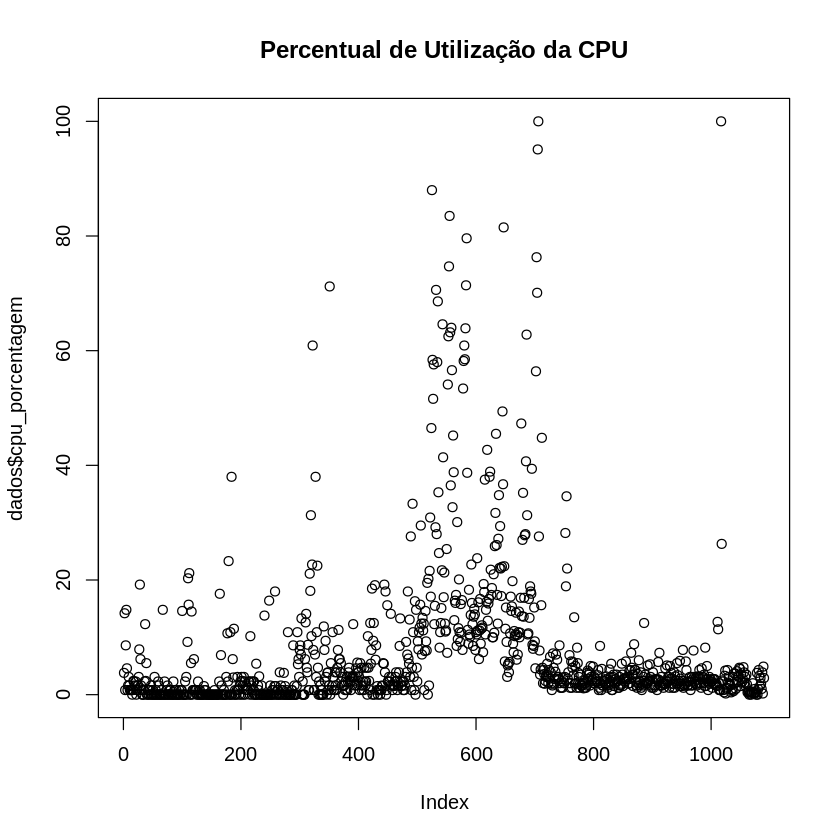

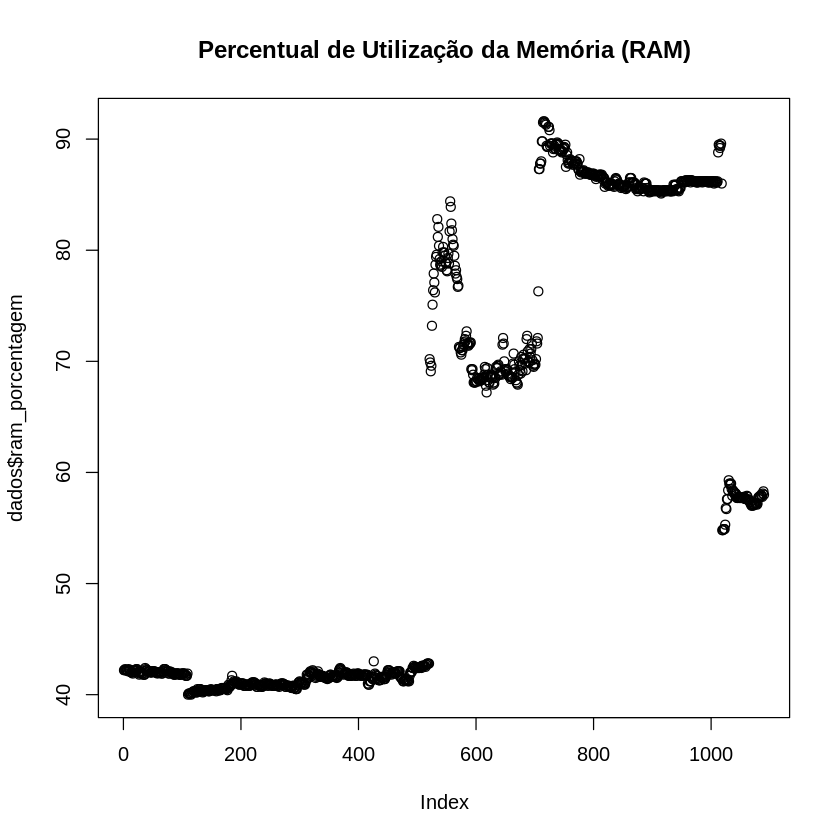

In [13]:
plot(dados$cpu_porcentagem, main = "Percentual de Utilização da CPU")
plot(dados$ram_porcentagem, main = "Percentual de Utilização da Memória (RAM)")

Com esses graficos, podemos ver que os dados capturados variam bastante, devido a diferença de maquinas que deram os dados, logo devemos desconsiderar certas relações

Em seguida, analisamos quais dados tem correlação significativa, no caso, foi escolhido a parti de 0.39 para a correlação ser considerada forte

In [14]:
relacoes_uso_cpu <- cor(dados$cpu_porcentagem, dados[,-1])
names(relacoes_uso_cpu) <- colnames(dados[,-1])

correlacoes_significativas_cpu <- relacoes_uso_cpu[abs(relacoes_uso_cpu) >= 0.39]
correlacoes_significativas_cpu

cpu_ociosa_porcentagem cpu_usuarios_porcentagem  cpu_sistema_porcentagem 
              -1.0000000                0.9655547                0.9346501 
    disco_throughput_mbs     disco_throughput_gbs 
               0.4057711                0.3987123

Resultados:

    cpu_usuarios_porcentagem  -> 0.9655
    cpu_sistema_porcentagem   -> 0.9346
    disco_throughput_mbs      -> 0.4057
    disco_throughput_gbs      -> 0.3987

Essas variáveis são as mais relevantes para a nossa analise do uso da CPU.

Agora fizemos a analise sobre o R² da utilização do usuario em relação ao total da CPU e da utilização do sistema em relação à CPU

In [15]:
  correlacao_usuario <- cor(dados$cpu_porcentagem, dados$cpu_usuarios_porcentagem)

  print(correlacao_usuario * correlacao_usuario)
  # 93% - Extremamente relevante

  correlacao_sistema <- cor(dados$cpu_porcentagem, dados$cpu_sistema_porcentagem)

  print(correlacao_sistema * correlacao_sistema)
  # 87% - Extremamente relevante

[1] 0.9322958
[1] 0.8735707


Concluimos que a correlação da CPU usada pelo usuario com a CPU total é maior que a da CPU usada pelo sistema em relação à total

Para entender melhor, analisamos o quanto o uso da CPU pelo usuário impacta diretamente na utilização da CPU pelo sistema.

In [16]:
 correlacao_partes <- cor(dados$cpu_usuarios_porcentagem, dados$cpu_sistema_porcentagem)

  print(correlacao_partes ^2)
  # 66%

[1] 0.6609507


Com isso, é possível ver que há uma interferencia muito forte de uma variavel para outra, logo não faz sentido ter as duas como metricas

Escolhendo a mais adequada:

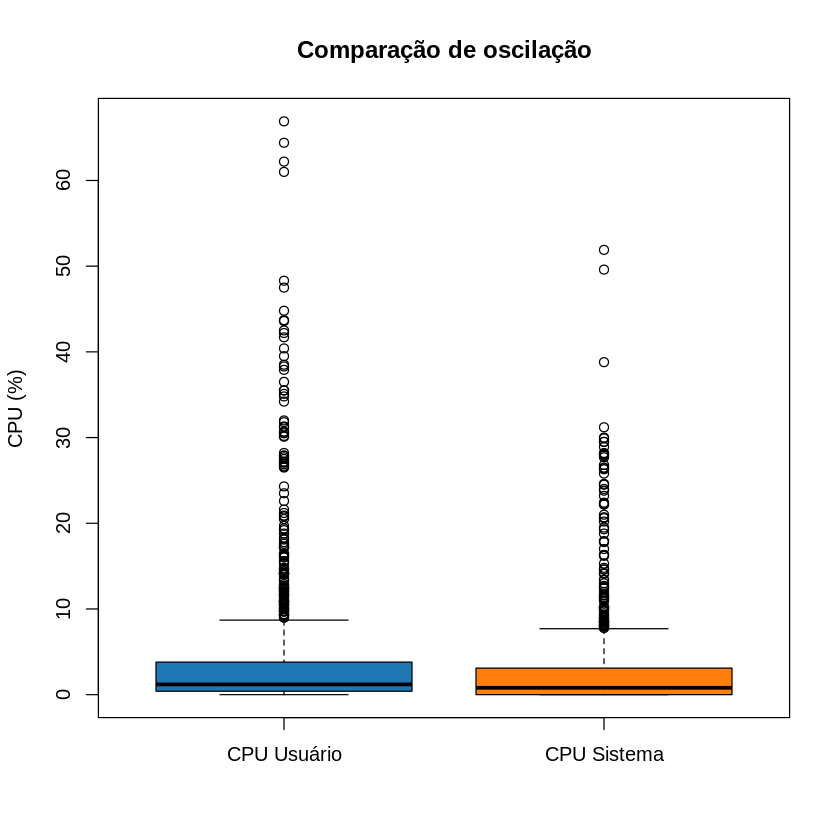

In [17]:
    boxplot(dados$cpu_usuarios_porcentagem,
            dados$cpu_sistema_porcentagem,
            names = c("CPU Usuário", "CPU Sistema"),
            col = c("#1f77b4", "#ff7f0e"),
            border = "black",
            main = "Comparação de oscilação",
            ylab = "CPU (%)")

Com isso e com pesquisas externas, podemos concluir que a cpu_sistema oscila menos e influencia menos na CPU total, logo escolhemos a cpu_usuario para dar como metrica

In [ ]:
    plot(dados$cpu_porcentagem, dados$cpu_usuarios_porcentagem,
         main = "Relação entre Uso de CPU e Disco Throughput",
         xlab = "CPU (%)",
         ylab = "Disco Throughput (MB/s)",
         col = "blue")

    abline(lm(cpu_usuarios_porcentagem ~ cpu_porcentagem, data = dados))


Estabelecendo as correlações entre o disco throughput e o uso de CPU:

Sendo cpu_usuario e disco_throughput_mbs as metricas para CPU

In [ ]:
correlacao_cpu_disco <- cor(dados$cpu_porcentagem, dados$disco_throughput_mbs)
print(correlacao_cpu_disco ^2)
# 16.45% - Relação fraca, mas existente.

plot(dados$cpu_porcentagem, dados$disco_throughput_mbs,
     main = "Relação entre Uso de CPU e Disco Throughput (MB/s)",
     xlab = "CPU (%)",
     ylab = "Disco Throughput (MB/s)",
     col = "blue")

abline(lm(disco_throughput_mbs ~ cpu_porcentagem, data = dados))

# Vendo relações com a RAM



Agora, repetimos o processo para a RAM, observando quais variáveis
têm relação direta com seu uso total.

In [ ]:
relacoes_uso_ram <- cor(dados$ram_porcentagem, dados[,-c(5,6,7,8,9,10)])

names(relacoes_uso_ram) <- colnames(dados[,-c(5,6,7,8,9,10)])

colnames(relacoes_uso_ram)

correlacoes_significativas_ram <- relacoes_uso_ram[abs(relacoes_uso_ram) >= 0.39]

correlacoes_significativas_ram

# Resultado:
# ram_swap_porcentagem -> 0.5567 (única relação significativa)
print(0.5566794 ^2)
# 30.98% - Parte considerável do uso total de RAM é explicada pela swap.

Fazendo a regressão linear do swap de memoria e da memoria total

In [ ]:
plot(dados$ram_porcentagem, dados$ram_swap_porcentagem,
     main = "Relação entre RAM Total e RAM Swap",
     xlab = "RAM Total (%)",
     ylab = "RAM Swap (%)",
     col = "green")

abline(lm(ram_swap_porcentagem ~ ram_porcentagem, data = dados))

# DEFININDO LIMITES DE ALERTA

In [ ]:
box_cpu <- boxplot(dados$cpu_porcentagem,
                   main = "Distribuição do Uso de CPU (%)")

box_cpu$stats

# Definindo resultados:
# - Valor máximo (sem outliers): 18.3%
# - Considerando 3 containers por servidor: Limite total ≈ 54.9%
# - Faixas sugeridas:

#     - Alerta medio: 54.9%
#     - Alerta alto:82.3%

In [ ]:
box_ram <- boxplot(dados$ram_porcentagem,
                   main = "Distribuição do Uso de RAM (%)")

box_ram$stats

# Interpretação:
# - Q3 (topo da caixa): 85.4%
# - Q4 (Bigode superior): 91.6%
# - Uso acima de 91.6% pode ser considerado arriscado, por ser um outlier

#     - Alerta medio: 85.4%
#     - Alerta alto: 91.6%